<a href="https://colab.research.google.com/github/Deepa018-coder/Molecule_Solubility_Predictor_4749.ipynb/blob/main/Molecule_Solubility_Predictor_4749.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
# ============================================================
!pip install rdkit-pypi pandas seaborn scikit-learn tqdm "numpy<2.0" -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Mount Drive (if the CSV is in Drive)
# ------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Path to your file – adjust if necessary
csv_path = '/content/Smiles_unique.csv'   # <— change if in another folder

Mounted at /content/drive


In [ ]:
# ------------------------------------------------------------
import pandas as pd
df = pd.read_csv(csv_path)
print(df.head())

                                              SMILES
0  CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C...
1  CC1=C(C(=O)N2CCCC(C2=N1)O)CCN3CCC(CC3)C4=NOC5=...
2  CCCCCCCCCCCCCCCC(=O)OC1CCCN2C1=NC(=C(C2=O)CCN3...
3  CC1=C(C(=O)N2CCC[C@H](C2=N1)O)CCN3CCC(CC3)C4=N...
4  CC1=CC=CN2C1=NC(=C(C2=O)CCN3CCC(CC3)C4=NOC5=C4...


In [ ]:
# ------------------------------------------------------------
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
from math import log10
from tqdm.auto import tqdm
import numpy as np # Import numpy
import pandas as pd # Import pandas as it might be needed explicitly

# Simplify esol_logS to just the final calculation
def esol_logS_formula(mw, logP, rotables, aromatic_proportion):
    '''
    Delaney ESOL (2004) logS formula.
    '''
    logS = 0.16 - 0.63*logP - 0.0062*mw + 0.066*rotables - 0.74*aromatic_proportion
    return logS       # higher = more soluble

# Ensure the 'mol' column exists and is populated
df['mol'] = df['SMILES'].progress_apply(Chem.MolFromSmiles)

# Identify and report invalid SMILES strings (where mol is None)
invalid_smiles_df = df[df['mol'].isnull()]
if not invalid_smiles_df.empty:
    print(f"Warning: Could not parse {len(invalid_smiles_df)} SMILES strings. These rows will be excluded from descriptor calculation.")
    # Optional: Print the invalid SMILES strings
    # print("Invalid SMILES strings:")
    # for index, row in invalid_smiles_df.iterrows():
    #     print(f"Index {index}: {row['SMILES']}")

# Filter out rows with invalid SMILES before calculating descriptors
df_valid = df[df['mol'].notnull()].copy()

# Initialize columns for descriptors and LogS with NaN in the original dataframe first
df['MW'] = np.nan
df['LogP'] = np.nan
df['RotatableBonds'] = np.nan
df['AromaticProportion'] = np.nan
df['LogS'] = np.nan


# Iterate through valid molecules and calculate descriptors and LogS
for index, row in tqdm(df_valid.iterrows(), total=len(df_valid), desc="Calculating Descriptors and LogS"):
    mol = row['mol']
    try:
        # Calculate descriptors
        mw = Descriptors.MolWt(mol)
        logP = Crippen.MolLogP(mol)
        rotables = Descriptors.NumRotatableBonds(mol)

        # Handle aromatic proportion calculation
        if mol.GetNumAtoms() == 0:
            aromatic_proportion = 0.0
        else:
            aromatic_atoms = sum(a.GetIsAromatic() for a in mol.GetAtoms())
            aromatic_proportion = aromatic_atoms / mol.GetNumAtoms()

        # Store calculated descriptors back in the *original* dataframe using the original index
        original_index = row.name # Get the original index
        df.loc[original_index, 'MW'] = mw
        df.loc[original_index, 'LogP'] = logP
        df.loc[original_index, 'RotatableBonds'] = rotables
        df.loc[original_index, 'AromaticProportion'] = aromatic_proportion

        # Calculate and store LogS
        df.loc[original_index, 'LogS'] = esol_logS_formula(mw, logP, rotables, aromatic_proportion)

    except Exception as e:
        # Catch any errors during descriptor calculation for this row
        original_index = row.name
        print(f"Error calculating descriptors for SMILES: {row['SMILES']} at original index {original_index} - {e}")
        # LogS and descriptors for this row will remain NaN as initialized


# Report SMILES strings that had calculation errors (mol is not None, but LogS is NaN)
# Need to check in the original df
calculation_errors_df = df[(df['mol'].notnull()) & (df['LogS'].isnull())]
if not calculation_errors_df.empty:
     print(f"Warning: Could not calculate LogS for {len(calculation_errors_df)} molecules due to calculation errors.")
     # Optional: Print SMILES strings with calculation errors
     # print("SMILES strings with calculation errors:")
     # for index, row in calculation_errors_df.iterrows():
     #     print(f"Index {index}: {row['SMILES']}")


print(df[['SMILES','LogS']].head())

  0%|          | 0/4748 [00:00<?, ?it/s]

[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not removing hydrogen atom without neighbors
[10:24:27] WARNING: not r

[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not removing hydrogen atom without neighbors
[10:24:28] WARNING: not r

Calculating Descriptors and LogS:   0%|          | 0/4747 [00:00<?, ?it/s]

                                              SMILES      LogS
0  CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C... -4.753021
1  CC1=C(C(=O)N2CCCC(C2=N1)O)CCN3CCC(CC3)C4=NOC5=... -4.519547
2  CCCCCCCCCCCCCCCC(=O)OC1CCCN2C1=NC(=C(C2=O)CCN3... -8.681191
3  CC1=C(C(=O)N2CCC[C@H](C2=N1)O)CCN3CCC(CC3)C4=N... -4.519547
4  CC1=CC=CN2C1=NC(=C(C2=O)CCN3CCC(CC3)C4=NOC5=C4... -5.165230


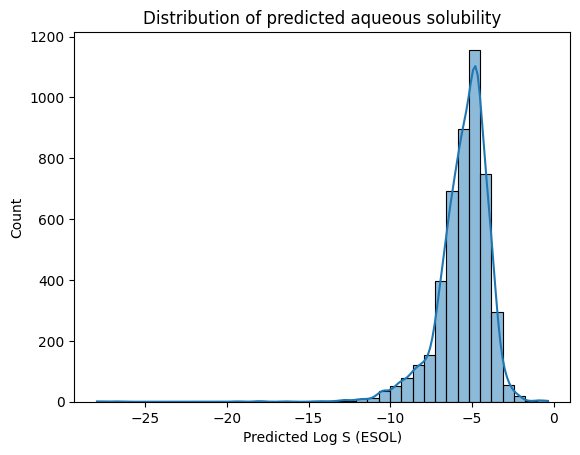

In [ ]:
# Quick distribution plot
# ------------------------------------------------------------
import seaborn as sns, matplotlib.pyplot as plt
sns.histplot(df['LogS'], bins=40, kde=True)
plt.xlabel('Predicted Log S (ESOL)')
plt.title('Distribution of predicted aqueous solubility')
plt.show()

In [ ]:
# IC50 handling
# ------------------------------------------------------------
# If you already HAVE experimental IC50 values:
#  - Add a column ‘IC50_nM’ (or whatever units) to your CSV.
#  - Reload and treat it like any numeric column (plot, regressions…)

# If you do NOT have them and want to PREDICT IC50:
#  (a) Decide which target protein the IC50 refers to!
#  (b) Gather a public dataset for that target (ChEMBL, PubChem).
#  (c) Split: train / valid / test.
#  (d) Train a QSAR / deep-learning model on molecular descriptors or fingerprints.
#  (e) Use it to predict IC50 for this SMILES list.

# Example skeleton for fingerprint + RandomForest model  (needs a labelled set)
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas

def featurize(smiles):
    # Ensure mol is not None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Ensure the fingerprint is converted to a list
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return list(fp)
    else:
        return None # Return None for invalid SMILES

# The following code is commented out because it requires a labelled dataset (bio_df)
# If you have a labelled dataset, uncomment and adapt the code below:

# Suppose you collected a dataframe `bio_df` with columns ['SMILES','IC50_nM']
# bio_df['X'] = bio_df['SMILES'].apply(featurize)
#
# # Filter out rows where featurization failed
# bio_df_valid = bio_df[bio_df['X'].notnull()].copy()
#
# if not bio_df_valid.empty:
#     X = list(bio_df_valid['X'])
#     y = bio_df_valid['IC50_nM']
#
#     # Check if there's enough data for splitting
#     if len(X) > 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
#         model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
#         model.fit(X_train, y_train)
#
#         print('Test R²:', model.score(X_test, y_test))
#
#         # Predict IC50 for the original dataframe (handling potential invalid SMILES)
#         df['IC50_pred_nM'] = df['SMILES'].apply(lambda s: model.predict([featurize(s)])[0] if featurize(s) is not None else np.nan)
#     else:
#         print("Warning: Not enough valid data to train a model.")
# else:
#     print("Warning: No valid molecules for featurization from the labelled dataset.")

In [ ]:
# Save results back to Drive
# ------------------------------------------------------------
out_path = '/content/drive/MyDrive/Smiles_unique_with_LogS.csv'
df.drop(columns=['mol']).to_csv(out_path, index=False)
print('Saved:', out_path)

Saved: /content/drive/MyDrive/Smiles_unique_with_LogS.csv
